# Part I. One-sided finite differences

Write a function, `deriv`, which computes a derivative of its argument at a given point, $x$, using a one-sided finite difference rule with a given step side $h$, with the approximation order of $O(h^2)$. 

In [1]:

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def deriv(f, x, h):
    """ Compute a derivative of `f` at point `x` with step size `h`.
    
    Compute the derivative using the one-sided rule of the approximation order of $O(h^2)$.
    
    Parameters
    ----------
    f : callable
        The function to differentiate
    x : float
        The point to compute the derivative at.
    h : float
        The step size for the finite different rule.
        
    Returns
    -------
    fder : derivative of f(x) at point x using the step size h.
    """
    return (-1.5*f(x)+2*f(x + h) - 0.5*f(x + 2*h))/h

#### Test I.1

Test your function on a simple test case: differentiate $f(x) = x^3$ at $x=0$. Comment on whether your results are consistent with the expected value of $f'(x) = 0$ and on an expected scaling with $h\to 0$.

 (10% of the total grade)

In [3]:
x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(lambda x: x**3, x, h) 
    print("%5f -- %7.4g" % (h, err))

0.010000 -- -0.0002
0.001000 --  -2e-06
0.000100 --  -2e-08
0.000010 --  -2e-10


все хорошо, ошибка квадратично зависит от h, как и должно быть

### Test I.2

Now use a slightly more complicated function, $f(x) = x^2 \log{x}$, evaluate the derivative at $x=1$ using your one-sided rule and a two-point one-sided rule. Roughly estimate the value of $h$ where the error stops decreasing, for these two schemes. 
(15% of the total grade)

In [4]:
from math import log

def f(x):
    return x**2 * log(x)
    
def fder(x):
    return x * (2.*log(x) + 1)

In [5]:
def tpos(f, x, h): # tpos - two-point one-side
    return (f(x+h) - f(x))/h

In [6]:
r = fder(1) #много вызывается, надо запомнить
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(f, 1, h) - r 
    err2 = tpos(f, 1, h) - r
    print("%5f -- %7.4g -- %7.4g" % (h, err, err2))

0.010000 -- -6.617e-05 -- 0.01503
0.001000 -- -6.662e-07 --  0.0015
0.000100 -- -6.666e-09 -- 0.00015
0.000010 -- -4.901e-11 -- 1.5e-05


Видно, что тупой метод сильно хуже не совсем тупого, что ожидаемо.  
Давайте посмотрим в лог-лог масштабе

In [7]:
h = np.logspace(-2, -16, 1000)
deriv_vec = np.vectorize(deriv)
tpos_vec = np.vectorize(tpos) #чтобы можно было передать им лист h и получить в ответ лист

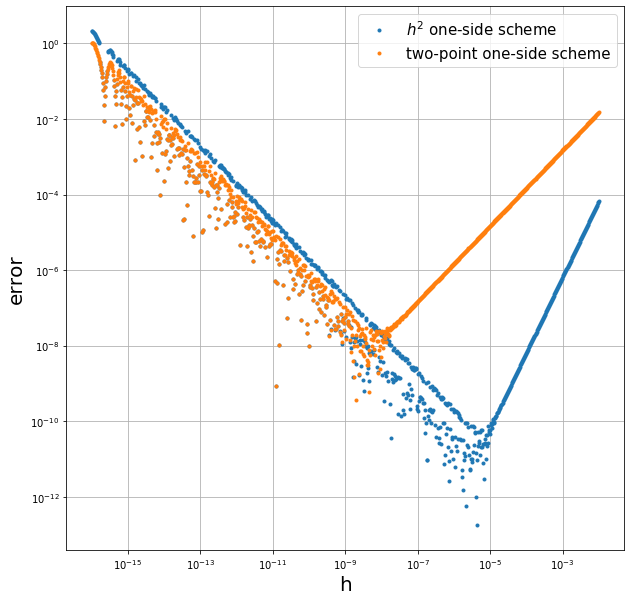

In [8]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(h, np.abs(deriv_vec(f, 1, h) - r), '.', label = '$h^2$ one-side scheme')
ax.plot(h, np.abs(tpos_vec(f, 1, h) - r), '.', label = "two-point one-side scheme")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('h', fontsize = 20)
ax.set_ylabel('error', fontsize = 20)
ax.grid('True')
ax.legend(fontsize = 15)

Картинка такая, какой и ожидалась, $h^2$ метод оказывается точнее и достигает минимума раньше, чем самый обычный метод

### Test I.3 

Now try differentiating $x^2 \log(x)$ at $x=0$. Use the three-point one-sided rule. Note that to evaluate the function at zero, you need to special-case this value. Check the scaling of the error with $h$, explain your results. 
(25% of the total grade)

In [9]:
def f(x):
    if x == 0:
        # the limit of $x^2 log(x)$ at $x-> 0$ is zero, even though log(x) is undefined at x=0
        return 0.0
    else:
        return x**2 * log(x)
    
def fder(x):
    if x == 0:
        return 0.0
    else:
        return x*(2*log(x) + 1)

x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(f, x, h) - fder(x)
    print("%5f -- %7.4g" % (h, err))

0.010000 -- -0.01386
0.001000 -- -0.001386
0.000100 -- -0.0001386
0.000010 -- -1.386e-05


In [10]:
h = np.logspace(-2, -30, 1000)
deriv_vec = np.vectorize(deriv)

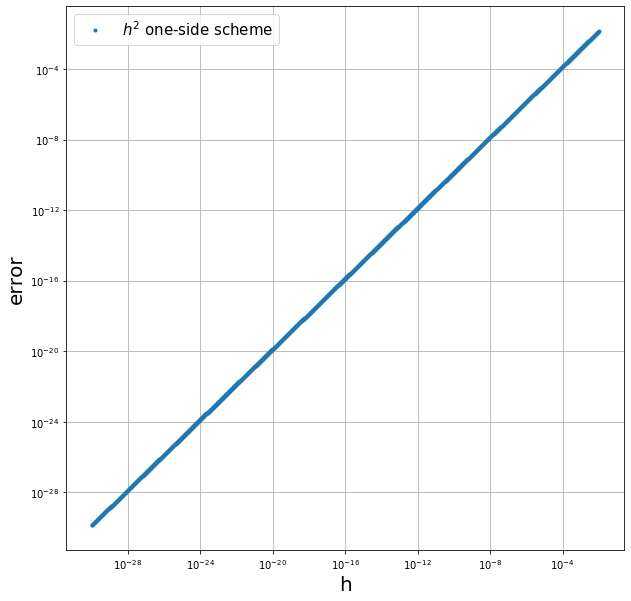

In [11]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(h, np.abs(deriv_vec(f, 0, h) - fder(0)), '.', label = '$h^2$ one-side scheme')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('h', fontsize = 20)
ax.set_ylabel('error', fontsize = 20)
ax.grid('True')
ax.legend(fontsize = 15)

Ясно, что что-то не так, потому что на $10^{-30}$ арифметика должна была сломаться, но нет  
Что по сути вычисляет функция с учетом того, что $f(0)= 0$? Вот такую штуку $\dfrac{2f(h) - f(2h)/2}{h} = -2h Log(2)$  
Теперь понятна линейная зависимость. Но почему схема, от которой мы ожидали кваратичной зависимости по построению выдала линейную? Потому что выводили мы эту схему опираясь на разложение в ряд Тейлора, но $log$ в нуле в тейлора никак не раскладывается, соответсвенно необходимые условия для работы метода просто не соблюдены, вот он и не работает

# Part II. Midpoint rule 

Write a function which computes a definite integral using the midpoint rule up to a given error, $\epsilon$. Estimate the error by comparing the estimates of the integral at $N$ and $2N$ elementary intervals. 

In [12]:
def midpoint_rule(func, a, b, eps):
    """ Calculate the integral of f from a to b using the midpoint rule.
    
    Parameters
    ----------
    func : callable
        The function to integrate.
    a : float
        The lower limit of integration.
    b : float
        The upper limit of integration.
    eps : float
        The target accuracy of the estimate.b
        
    Returns
    -------
    integral : float
        The estimate of $\int_a^b f(x) dx$.
    """
    i = func((a + b)/2)*(b - a)
    N = 2
    err = []
    #print(i)
    for j in range(100): #чтобы в бесконечный цикл не улететь
        h = (b-a)/N
        i_new = h*np.sum(func(np.linspace(a, b - h, N) + h/2))
        err.append(np.abs(i_new - i))
        #print(i_new)
        if np.abs(i - i_new) < eps:
            return i, np.array(err)
        else:
            i = i_new
            N *=2

In [13]:
fx3 = np.vectorize(lambda x: x**3)

In [14]:
midpoint_rule(fx3, 0, 1, 0.001)

(0.24951171875,
 array([0.09375   , 0.0234375 , 0.00585938, 0.00146484, 0.00036621]))

оно работает! И ошибка уходит как раз по квадрату. N возрастает на каждом шаге в 2 раза, а ошибка уменьшается в 4

### Test II.1

Test your midpoint rule on a simple integral, which you can calculate by paper and pencil.

Compare the rate of convergence to the expected $O(N^{-2})$ scaling by studying the number of intervals required for a given accuracy $\epsilon$.

Compare the numerical results to the value you calculated by hand. Does the deviation agree with your estimate of the numerical error?
(20% of the total grade)


In [15]:
midpoint_rule(np.exp, 0, 1, 1e-10)

(1.7182818283923673,
 array([5.17914460e-02, 1.33025631e-02, 3.34838522e-03, 8.38527057e-04,
        2.09721331e-04, 5.24359330e-05, 1.31093333e-05, 3.27735520e-06,
        8.19340168e-07, 2.04835128e-07, 5.12087874e-08, 1.28021969e-08,
        3.20054938e-09, 8.00137512e-10, 2.00034433e-10, 5.00084418e-11]))

Вроде бы похоже на число эйлера и сходимость квадратичная, ок

In [16]:
gauss = np.vectorize(lambda x: np.exp(-x**2))
midpoint_rule(gauss, -10, 10, 1e-10)

(1.77245385086779,
 array([2.00000000e+01, 1.93045411e-02, 1.02875630e+00, 7.17990304e-01,
        6.40270511e-03, 3.77258225e-11]))

In [17]:
np.pi**0.5

1.7724538509055159

Что-то даже близкое к верному ответу. Такое прокатывает, потому что гауссиан неприлично быстро сходится

### Test II.2

Now use your midpoint rule to compute the value of

$$
\int_0^1\! \frac{\sin{\sqrt{x}}}{x}\, dx
$$

up to a predefined accuracy of $\epsilon=10^{-4}$.

Note that the integral contains an integrable singularity at the lower limit. Do calculations two ways: first, do a straightforward computation; next, subtract the singularity. Compare the number of iterations required to achieve the accuracy of $\epsilon$.

(30% of the total grade)

In [18]:
fsi = np.vectorize(lambda x: np.sin(np.sqrt(x))/x)

In [19]:
midpoint_rule(fsi, 0, 1, 1e-3) #на 1е-10 запускать плоха идея

(1.8888245145715272,
 array([0.16741719, 0.12324037, 0.0882944 , 0.06265017, 0.04432536,
        0.03133844, 0.02215479, 0.01566327, 0.0110745 , 0.00783041,
        0.00553677, 0.00391502, 0.00276832, 0.00195749, 0.00138415,
        0.00097874]))

Квадратичной сходимости что-то не наблюдается. Даже линейной не наблюдается.  
Делаем элементарную замену $x = y^2$  и получаем

In [20]:
fsi2 = np.vectorize(lambda x: 2*np.sin(x)/x)

Ну вот, никаких сингулярностей. Такого рода замена равносильна уплотнению сетки в нуле, так как мы переписываем меру интегрирования таким образом, что она "уплотняется" ближе к нулю

In [22]:
midpoint_rule(fsi2, 0, 1, 1e-10)

(1.892166140827861,
 array([1.92346374e-02, 4.73110605e-03, 1.17801843e-03, 2.94208590e-04,
        7.35336676e-05, 1.83822622e-05, 4.59549340e-06, 1.14886884e-06,
        2.87216928e-07, 7.18042146e-08, 1.79510526e-08, 4.48776283e-09,
        1.12194076e-09, 2.80485413e-10, 7.01212421e-11]))